# Set Up

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import off_sample_utils as utils

/data/intsco/miniconda3/envs/off-smpl/lib/python3.6/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array
Using TensorFlow backend.


In [3]:
# %run off_sample/utils.py

In [4]:
image_shape = (64, 64)
gs_path = Path('./GS/raw_images/')
all_paths = utils.get_ds_paths(gs_path)
len(all_paths)
# len(list(data_path.iterdir()))

66

# Check Hardware and Tools

In [5]:
utils.check_tf_dev()

1.12.0
name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6595688852596339051

name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12922128425669364754
physical_device_desc: "device: XLA_GPU device"

name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 3211508405338605535
physical_device_desc: "device: XLA_CPU device"

name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11281553818
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12201508104934288452
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"



In [6]:
from skimage import transform
import imageio
import keras
import numpy as np
import pandas as pd
import sklearn
import matplotlib
keras.__version__, pd.__version__, np.__version__, matplotlib.__version__, sklearn.__version__

('2.2.4', '0.23.4', '1.12.1', '2.0.2', '0.20.0')

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline

# Load Data

In [8]:
import random
import pickle
import warnings
import numpy as np

In [27]:
warnings.filterwarnings('ignore', message='Possible precision loss')

X_list, y_list, groups = [], [], []

for ds_path in all_paths:
    mask_path = ds_path / 'mask.pkl'
    mask = pickle.load(open(mask_path, 'rb'))
    mask = utils.resize_image(mask)
    inv_mask = abs(mask - 1)
    for img_class in ['on', 'off']:
        for img_path in (ds_path / img_class).iterdir():
            img = utils.read_resize(img_path)
            img_3ch = np.stack([img, mask, inv_mask], axis=2)
            
            X_list.append(img_3ch)
            y_list.append(1 if img_class == 'off' else 0)
            groups.append(ds_path.name)

X = np.stack(X_list)

y = np.stack(y_list)
y = y.reshape(y.shape + (1,))
y = keras.utils.to_categorical(y, 2)

groups = np.stack(groups)

X.shape, y.shape, groups.shape

((18038, 64, 64, 3), (18038, 2), (18038,))

In [11]:
pd.value_counts(y[:,1])

0.0    10307
1.0     7731
dtype: int64

In [12]:
u_groups = np.unique(groups)
len(u_groups)

66

In [13]:
# %run off_sample_utils/

# Train and Test Model

In [31]:
import pickle
import keras
import sklearn
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_curve, roc_auc_score, accuracy_score, f1_score,
                             precision_score, recall_score, average_precision_score)

In [32]:
other_u_groups, test_u_groups = train_test_split(u_groups, test_size=0.2, random_state=13)
other_u_groups.shape, test_u_groups.shape

((52,), (14,))

In [33]:
X_other, y_other, groups_other = utils.make_subset(other_u_groups, X, y, groups)
X_test, y_test, groups_test = utils.make_subset(test_u_groups, X, y, groups)

In [35]:
train_u_groups, valid_u_groups = train_test_split(other_u_groups, test_size=0.2, random_state=13)
train_u_groups.shape, valid_u_groups.shape

((41,), (11,))

In [17]:
# X_train, y_train, _ = utils.make_subset(train_u_groups, X, y, groups, to_rgb=True)

In [18]:
# i = 0
# img = X_train[i].copy() * 255.
# utils.plot_images([img, vgg16.preprocess_input(img, mode='tf')])

### Dataset Sampling

In [21]:
import pickle
from pathlib import Path

In [145]:
sample_path = Path('Xygroups_sample.pkl')
if sample_path.exists():
    X_sample, y_sample, groups_sample = pickle.load(open(sample_path, 'rb'))
else:
    X_sample_list = []
    y_sample_list = []
    groups_sample_list = []

    for g in other_u_groups:
        g_off = (groups_other == g)&(y_other[:,1] == 1)
        g_on = (groups_other == g)&(y_other[:,1] == 0)

        on_inds = np.arange(X_other[g_on].shape[0])
        on_sample_inds = np.random.choice(on_inds, int(round(on_inds.shape[0] / 5)), replace=False)
        off_inds = np.arange(X_other[g_off].shape[0])
        off_sample_inds = np.random.choice(off_inds, int(round(off_inds.shape[0] / 5)), replace=False)

        X_sample_list.append(np.concatenate([X_other[g_on][on_sample_inds],
                                             X_other[g_off][off_sample_inds]]))
        y_sample_list.append(np.concatenate([y_other[g_on][on_sample_inds],
                                             y_other[g_off][off_sample_inds]]))
        groups_sample_list.append(np.concatenate([groups_other[g_on][on_sample_inds],
                                                  groups_other[g_off][off_sample_inds]]))

    X_sample = np.concatenate(X_sample_list)
    X_sample.setflags(write=False)
    y_sample = np.concatenate(y_sample_list)
    y_sample.setflags(write=False)
    groups_sample = np.concatenate(groups_sample_list)
    groups_sample.setflags(write=False)

In [146]:
X_sample[0].shape

(64, 64, 1)

In [24]:
# pickle.dump((X_sample, y_sample, groups_sample), open('Xygroups_sample.pkl', 'wb'))

In [36]:
from keras import backend as K
from keras.applications import VGG16, VGG19, ResNet50
from keras.applications import vgg16
from keras.models import Model, Sequential
from keras.layers import (Activation, BatchNormalization, Conv2D, InputLayer, Dropout, Dense, Flatten)
from keras.metrics import binary_accuracy
from keras.losses import binary_crossentropy
from keras.regularizers import l2
from keras.models import Model
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint
import warnings

### Custom CNN model

In [37]:
warnings.filterwarnings('ignore', message=r'\bExpected input to be images\b')
warnings.filterwarnings('ignore', message=r'\bNumpyArrayIterator is set to use the data format convention\b')

data_gen_args = dict(
            featurewise_center=True,
            featurewise_std_normalization=True,
            rotation_range=5,
            width_shift_range=0.05,
            height_shift_range=0.05,
            horizontal_flip=True,
            vertical_flip=True,
            rescale=0.1)

X_train, y_train, _ = utils.make_subset(train_u_groups, X, y, groups)
X_valid, y_valid, _ = utils.make_subset(valid_u_groups, X, y, groups)
data_gen = utils.OffSampleImageDataGenerator(**data_gen_args)
data_gen.fit(X_train)
X_valid = data_gen.standardize(X_valid)

custom_model = utils.create_model(
    input_shape=(64, 64, 3),
    opt=keras.optimizers.Adam(lr=1e-4),
    l1_a=0, l2_a=0.001,
    init_filters=8,
    dropout_p=0.5,
    dense_fn=(256, 256),
    act_f='relu',
    kernel_initializer='glorot_uniform',
    metrics=[keras.metrics.binary_accuracy])

seed = 13
batch_size = 32
epochs = 20
custom_cnn_save_path = 'custom-cnn-weights.hdf5'
checkpointer = ModelCheckpoint(filepath=custom_cnn_save_path, monitor='val_binary_accuracy',
                               verbose=1, save_best_only=True)
history = conversion_model.fit_generator(
    data_gen.flow(X_train, y_train, batch_size=batch_size, seed=seed),
    epochs=epochs, validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    callbacks=[checkpointer])

Epoch 1/20
345/344 [==============================] - 18s 53ms/step - loss: 0.8627 - binary_accuracy: 0.8740 - val_loss: 0.6325 - val_binary_accuracy: 0.9670

Epoch 00001: val_binary_accuracy improved from -inf to 0.96699, saving model to custom-cnn-weights.hdf5
Epoch 2/20
345/344 [==============================] - 13s 39ms/step - loss: 0.6129 - binary_accuracy: 0.9666 - val_loss: 0.5621 - val_binary_accuracy: 0.9731

Epoch 00002: val_binary_accuracy improved from 0.96699 to 0.97305, saving model to custom-cnn-weights.hdf5
Epoch 3/20
345/344 [==============================] - 13s 39ms/step - loss: 0.5350 - binary_accuracy: 0.9732 - val_loss: 0.5166 - val_binary_accuracy: 0.9672

Epoch 00003: val_binary_accuracy did not improve from 0.97305
Epoch 4/20
345/344 [==============================] - 13s 39ms/step - loss: 0.4801 - binary_accuracy: 0.9755 - val_loss: 0.4934 - val_binary_accuracy: 0.9591

Epoch 00004: val_binary_accuracy did not improve from 0.97305
Epoch 5/20
345/344 [=========

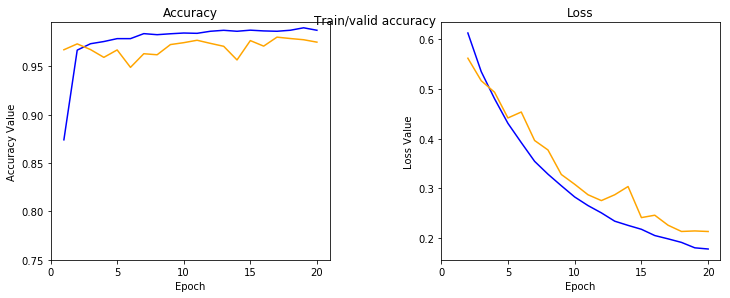

In [38]:
utils.plot_learning_graph([history.history], attempts=1)

In [40]:
X_test, y_test, _ = utils.make_subset(test_u_groups, X, y, groups)
X_test = data_gen.standardize(X_test)
y_proba = custom_model.predict(X_test)[:,1]
sklearn.metrics.accuracy_score(y_test[:,1], y_proba > 0.5)

0.98002378121284184

In [42]:
best_custom_model = utils.create_model(
    input_shape=(64, 64, 3),
    opt=keras.optimizers.Adam(lr=5e-5),
    l2_a=0.001,
    init_filters=8,
    dropout_p=0.5,
    dense_fn=(256, 256),
    act_f='relu',
    kernel_initializer='glorot_uniform',
    metrics=[keras.metrics.binary_accuracy])
best_custom_model.load_weights(custom_cnn_save_path)

X_test, y_test, _ = utils.make_subset(test_u_groups, X, y, groups)
X_test = data_gen.standardize(X_test)

In [43]:
y_proba = best_custom_model.predict(X_test)[:,1]
sklearn.metrics.accuracy_score(y_test[:,1], y_proba > 0.5)

0.98097502972651607

In [241]:
# convert_to_3ch_model = Model(inputs=best_conversion_model.layers[0].input,
#                              outputs=best_conversion_model.layers[2].output)
# to_3ch_model_weights_path = 'to_3ch_model_weights.hdf5'
# convert_to_3ch_model.save_weights(to_3ch_model_weights_path)

In [243]:
# X_train_3ch = convert_to_3ch_model.predict_on_batch(X_train)
# X_train_3ch.shape

In [244]:
# X_train_3ch.min(axis=(0,1,2)), X_train_3ch.max(axis=(0,1,2))

In [85]:
# X_train_3ch = convert_to_3ch_model_2.predict_on_batch(X_train)
# X_train_3ch.shape

### Transfer Learning

In [245]:
def make_2ch_3ch_converter(weights_path):
#     get_3rd_layer_output = K.function([conversion_model.layers[0].input, K.learning_phase()],
#                                       [conversion_model.layers[2].output])
    from keras.regularizers import l2

    model = Sequential(layers=[
        Conv2D(3, (1, 1), padding='same',
               input_shape=(image_shape + (2,)),
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Activation('relu')
    ])
    model.load_weights(weights_path)

    def min_max_normalize(X):
        assert X.ndim == 4
        mins, maxs = X.min(axis=(0,1,2)), X.max(axis=(0,1,2))
        print(mins, maxs)
        return (X - mins) / (maxs - mins + 1e-7)

    def converter(X):
        X_3ch = model.predict_on_batch(X)
        return min_max_normalize(X_3ch)

    return converter

In [246]:
coverter_to_3ch = make_2ch_3ch_converter(to_3ch_model_weights_path)

In [248]:
X_train, y_train, _ = utils.make_subset(train_u_groups, X, y, groups)
X_train_3ch = coverter_to_3ch(X_train)
X_train_3ch.shape

[  3.30415392   0.          12.41480637] [ 12.1768465    0.          24.08625221]


(11359, 64, 64, 3)

In [249]:
X_train_3ch.min(axis=(0,1,2)), X_train_3ch.max(axis=(0,1,2))

(array([ 0.,  0.,  0.], dtype=float32), array([ 1.,  0.,  1.], dtype=float32))

In [228]:
# backbone = VGG16(include_top=False, weights='imagenet', input_shape=(*image_shape, 3))
# [(i, l.name) for i, l in enumerate(backbone.layers)]

In [44]:
# %%time
X_train, y_train, _ = utils.make_subset(train_u_groups, X, y, groups)
X_valid, y_valid, _ = utils.make_subset(valid_u_groups, X, y, groups)

# coverter_to_3ch = make_2ch_3ch_converter(to_3ch_model_weights_path)
# X_train = coverter_to_3ch(X_train)
# X_valid = coverter_to_3ch(X_valid)
X_train.shape, X_valid.shape

((11031, 64, 64, 3), (2802, 64, 64, 3))

In [45]:
X_train.min(axis=(0,1,2)), X_train.max(axis=(0,1,2))

(array([ 0.        ,  0.33333333,  0.        ]),
 array([ 1.        ,  1.        ,  0.66666667]))

In [51]:
def vgg16_preprocess(X):
    return vgg16.preprocess_input(X.copy() * 255)

# def min_max_normalize(X):
#     assert X.ndim == 4
#     mins, maxs = X.min(axis=(0,1,2)), X.max(axis=(0,1,2))
#     return (X - mins) / (maxs - mins + 1e-7)

def create_fit_tl_model(X_train, y_train, X_valid=None, y_valid=None, verbose=0):
    ### Pretrain Top FC model
    K.clear_session()
    backbone = VGG16(include_top=False, weights='imagenet', input_shape=(*image_shape, 3))
#     backbone = ResNet50(include_top=False, weights='imagenet', input_shape=(*image_shape[:2], 3))

    epsilon = 1e-7
    X_mean = X_train.mean(axis=(0, 1, 2))
    X_std = X_train.std(axis=(0, 1, 2))

    def standardize(X):
        return (X - X_mean) / (X_std + epsilon)

    batch_size = 32
    bottleneck_features_train = backbone.predict(
        vgg16_preprocess(X_train), batch_size=batch_size)
    if X_valid is not None:
        bottleneck_features_valid = backbone.predict(
            vgg16_preprocess(X_valid), batch_size=batch_size)

    top_model = Sequential()
    top_model.add(InputLayer(input_shape=backbone.output_shape[1:]))
    top_model.add(Flatten())
    top_model.add(Dense(256, kernel_regularizer=l2(l=0.01)))
    top_model.add(BatchNormalization())
    top_model.add(Activation('relu'))
    top_model.add(Dropout(0.75))
    top_model.add(Dense(256, kernel_regularizer=l2(l=0.01)))
    top_model.add(BatchNormalization())
    top_model.add(Activation('relu'))
    top_model.add(Dropout(0.75))
    top_model.add(Dense(2, activation='sigmoid'))

    top_model.compile(loss=binary_crossentropy,
                      optimizer=RMSprop(lr=1e-4),
#                       optimizer=Adam(lr=1e-4),
                      metrics=[binary_accuracy])
    
    epochs = 15
    if X_valid is not None:
        validation_data = (bottleneck_features_valid, y_valid)
    else:
        validation_data = None
    top_model.fit(bottleneck_features_train, y_train,
                  epochs=epochs, batch_size=batch_size, verbose=verbose,
                  validation_data=validation_data)
    
    ### Backbone+Top Model Fine Tuning
    
    model = Model(inputs=backbone.input, outputs=top_model(backbone.output))
    n = 11  # the last 2 conv blocks of vgg16
#     n = 15 # the last conv block of vgg16
    for i, layer in enumerate(model.layers):
        layer.trainable = i >= n
#         layer.trainable = True

    model.compile(loss=binary_crossentropy,
                  optimizer=SGD(lr=1e-6, momentum=0.9),
#                   optimizer=Adam(lr=0.0001),
                  metrics=[binary_accuracy])
    
    data_gen = utils.OffSampleImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        zoom_range=0.2,
        preprocessing_function=vgg16_preprocess
    )
    data_gen.fit(X_train)
    
    if X_valid is not None:
        validation_data = (data_gen.standardize(X_valid), y_valid)
#         validation_data = (vgg16_preprocess(X_valid), y_valid)
    else:
        validation_data = None
    
    vgg_save_path = 'vgg-weights.hdf5'
    checkpointer = ModelCheckpoint(filepath=vgg_save_path, monitor='val_binary_accuracy',
                                   verbose=1, save_best_only=True)
    batch_size = 32
    epochs = 20
    model.fit_generator(data_gen.flow(vgg16_preprocess(X_train), y_train, batch_size=batch_size),
                          validation_data=validation_data,
                          steps_per_epoch=X_train.shape[0]/batch_size,
                          epochs=epochs, verbose=verbose,
                          callbacks=[checkpointer])
    return model, data_gen

In [52]:
model, data_gen = create_fit_tl_model(X_train, y_train, X_valid, y_valid, verbose=1)

Train on 11031 samples, validate on 2802 samples
Epoch 1/15
11031/11031 [==============================] - 3s 286us/step - loss: 5.4374 - binary_accuracy: 0.6814 - val_loss: 3.6608 - val_binary_accuracy: 0.8478
Epoch 2/15
11031/11031 [==============================] - 3s 228us/step - loss: 2.9260 - binary_accuracy: 0.8716 - val_loss: 2.3024 - val_binary_accuracy: 0.8845
Epoch 3/15
11031/11031 [==============================] - 3s 232us/step - loss: 1.8087 - binary_accuracy: 0.9350 - val_loss: 1.4881 - val_binary_accuracy: 0.9044
Epoch 4/15
11031/11031 [==============================] - 3s 232us/step - loss: 1.1461 - binary_accuracy: 0.9544 - val_loss: 1.0129 - val_binary_accuracy: 0.9065
Epoch 5/15
11031/11031 [==============================] - 3s 232us/step - loss: 0.7677 - binary_accuracy: 0.9619 - val_loss: 0.7343 - val_binary_accuracy: 0.9115
Epoch 6/15
11031/11031 [==============================] - 3s 232us/step - loss: 0.5574 - binary_accuracy: 0.9657 - val_loss: 0.5923 - val_bin

KeyboardInterrupt: 

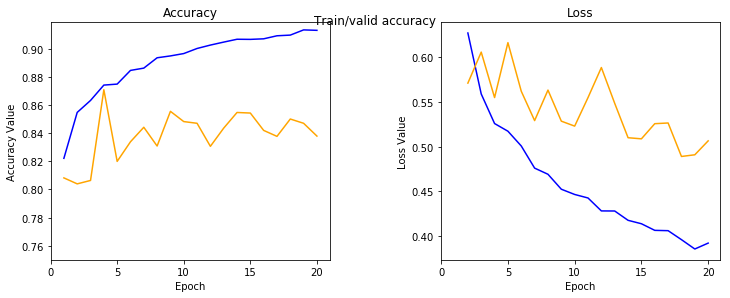

In [236]:
utils.plot_learning_graph([model.history.history], 1)

In [192]:
X_test, y_test, _ = utils.make_subset(test_u_groups, X, y, groups, to_rgb=False)
coverter_to_3ch = make_2ch_3ch_converter(to_3ch_model_weights_path)
X_test = coverter_to_3ch(X_test)
X_test = vgg16_preprocess(X_test)

y_proba = model.predict(X_test)
sklearn.metrics.accuracy_score(y_test[:,1], y_proba[:,1] > 0.5)

[ 0.          0.          6.87681866] [  5.85510254   0.          16.83978844]


0.96718192627824018

---

# Final Model Cross Validation

In [38]:
np.unique(groups).shape

(67,)

In [ ]:
%%time

folds = 5
# folds = 67
break_after_first_fold = False
attempts = 5

cv_groups = []
cv_metrics = []
history_list = []

X_rgb = convert_to_rgb(X)

gkfold = GroupKFold(n_splits=folds)
for fold_i, (train_inds, valid_inds) in enumerate(gkfold.split(X_rgb, y, groups)):
    print(f'Fold: {fold_i}', train_inds.shape, valid_inds.shape)
    cv_groups.append(np.unique(groups[valid_inds]).tolist())
    
    X_train, y_train = X_rgb[train_inds], y[train_inds]
    X_valid, y_valid = X_rgb[valid_inds], y[valid_inds]
    
    y_pred_avg = np.zeros(y_valid.shape)
    for i in range(attempts):
        print(f'Attempt: {i}')
        
        model, data_gen = create_fit_tl_model(X_train, y_train)
        history_list.append(model.history.history)
        
        y_pred = model.predict(data_gen.standardize(X_valid), verbose=0)
        y_pred_avg += y_pred
        
        metrics = calc_metrics(y_valid, y_pred)
        metrics['fold'] = fold_i
        metrics['attempt'] = i
        cv_metrics.append(metrics)

        print(metrics)
        print()
    
    print('Averaged')
    y_pred_avg /= attempts
    metrics = calc_metrics(y_valid, y_pred_avg)
    metrics['fold'] = fold_i
    metrics['attempt'] = 'avg'
    cv_metrics.append(metrics)  
    print(metrics)
    print()

    if break_after_first_fold:
        break

metrics_df = pd.concat(cv_metrics)
metrics_df.to_msgpack('metrics_df.msgpack')
pickle.dump(history_list, open('history_list.pkl', 'wb'))

Fold: 0 (14618,) (3627,)
Attempt: 0
           f1      prec    recall       acc  fold  attempt
on   0.979121  0.976961  0.981290  0.976565     0        0
off  0.973940  0.976086  0.971805  0.977116     0        0

Attempt: 1
           f1      prec    recall       acc  fold  attempt
on   0.983017  0.982776  0.983259  0.980976     0        1
off  0.978697  0.978697  0.978697  0.981252     0        1

Attempt: 2


In [41]:
df = metrics_df[metrics_df.attempt == 'avg']
df.groupby(df.index).agg([np.mean, np.std])

f1                prec              recall                acc  \
         mean       std      mean       std      mean      std      mean   
off  0.968437  0.016738  0.953225  0.032467  0.984625  0.00279  0.971401   
on   0.973778  0.013403  0.987164  0.001979  0.961059  0.02659  0.971457   

              fold            
          std mean       std  
off  0.014762    2  1.581139  
on   0.014839    2  1.581139

In [42]:
# df = metrics_df.loc['off']
metrics_df[metrics_df.attempt == 'avg'].loc['off'].agg([np.mean, np.std]).T

,mean,std
f1,0.968437,0.016738
prec,0.953225,0.032467
recall,0.984625,0.002790
acc,0.971401,0.014762
fold,2.000000,1.581139


In [43]:
# df = metrics_df.loc['on']
metrics_df[metrics_df.attempt == 'avg'].loc['on'].agg([np.mean, np.std]).T

,mean,std
f1,0.973778,0.013403
prec,0.987164,0.001979
recall,0.961059,0.026590
acc,0.971457,0.014839
fold,2.000000,1.581139


In [46]:
cv_groups

[['2017023_ADP_GFlarvae_55x55_40x40_DMAN002',
  'AstraZeneca__Rat_testis',
  'BRB04S-RECAL',
  'DESI porcine kidney interface region',
  'Dataset 26_recal',
  'Dataset 8',
  'Esco2_centroids',
  'ICL__LNTO26_7_3',
  'LNTO31_17_1-RECAL',
  'MP 39',
  'Mouse Kidney on plastic slide 260x175 30um',
  'Row001',
  'Tumor17'],
 ['20170105_VS_disc2_NEDC0001_70x80_10x10',
  '20170905_CGL0170817_MT-MB_ATP_N_81x101_135x135',
  'CC-Esco2_centroids',
  'Dataset 18',
  'Dataset 30',
  'ICL__A51 CT S3-centroid',
  'ICL__LNTO31_17_4',
  'ICL__LNTO41_17_2',
  'ICL__LNTO42_17_1',
  'Kidney_280x140_40um_E0',
  'MPIMM_021_QE_P_CB_0',
  'MS7_20170907_DHB_pos_MouseBrain_s3_300-1800_40um_245x134_A30-JBE-Test',
  'S648 WS20 205x170 20um E110',
  'Tumor11'],
 ['170418_MouseBrain_pos_50um_205by129_atn0',
  '20170815_CGL_MT-M.B_DAN012_NTM_42x30_100x100',
  'Dataset 16',
  'Dataset 27',
  'Dataset 31',
  'Dataset 3_recal',
  'Dataset 4_recal',
  'ICL__7TopRight,_17BottomRight,_27BottomLeft,_37TopLeft',
  'MPIMM_0

In [48]:
metrics_df[metrics_df.attempt == 'avg']

,f1,prec,recall,acc,fold,attempt
on,0.983736,0.984706,0.982767,0.981803,0,avg
off,0.979043,0.977514,0.980576,0.981527,0,avg
on,0.966084,0.985405,0.947505,0.965142,1,avg
off,0.964396,0.945574,0.983982,0.965414,1,avg
on,0.955224,0.989181,0.923521,0.950249,2,avg
off,0.944030,0.905188,0.986355,0.950249,2,avg
on,0.988375,0.988108,0.988643,0.988309,3,avg
off,0.988242,0.988512,0.987972,0.988309,3,avg
on,0.975470,0.988417,0.962858,0.971781,4,avg
off,0.966473,0.949335,0.984242,0.971507,4,avg


In [49]:
tup = (cv_groups, metrics_df[metrics_df.attempt == 'avg'])

In [51]:
pickle.dump(tup, open('cv_groups_metrcis.pkl', 'wb'))

---